# Baseline Model

In [2]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split

In [3]:
data_flight_info = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/Regression_no_outliers_cleaned_data_01.csv', sep = ',')

In [4]:
df_flight_info = data_flight_info.copy()
df_flight_info.isnull().sum()

fl_date                0
mkt_unique_carrier     0
op_unique_carrier      0
op_carrier_fl_num      0
origin                 0
crs_dep_time           0
dep_time               0
dep_delay              0
dest                   0
arr_time               0
arr_delay              0
crs_arr_time           0
crs_elapsed_time       0
actual_elapsed_time    0
distance               0
carrier_delay          0
weather_delay          0
nas_delay              0
security_delay         0
late_aircraft_delay    0
year                   0
month                  0
day                    0
weekday                0
dtype: int64

In [5]:
# Getting Average Carrier Delay - Grouped by Carrier
carrier_grouped = df_flight_info.groupby(by='op_unique_carrier').mean()
carrier_grouped.reset_index(inplace=True)
carrier_grouped['total_carrier_delay'] = carrier_grouped['carrier_delay'] + carrier_grouped['late_aircraft_delay']
carrier_grouped = carrier_grouped[['op_unique_carrier', 'total_carrier_delay']]
df_flight_info = df_flight_info.drop(['carrier_delay','late_aircraft_delay'],axis=1) 

# Model Training

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score, f1_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

## Feature Engineered Dataset

####  with Flight Number (onehot), average_route_time, total_security_delay, total_nas_delay

In [7]:
#### Shuffling dataset so model doesn't train on pattern

In [8]:
df_flight_info = shuffle(df_flight_info)
X = df_flight_info[['crs_dep_time','crs_elapsed_time','crs_arr_time','distance','year','month','day','weekday']]
y = df_flight_info['arr_delay']

In [9]:
X.shape

(578888, 8)

In [10]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

##### LightGBM

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1067
[LightGBM] [Info] Number of data points in the train set: 405221, number of used features: 8
[LightGBM] [Info] Start training from score 5.764284
Model RMSE is:  41.958851494727206
Model R2 Score is:  0.04061579104314583


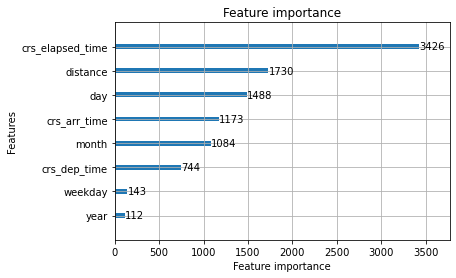

In [44]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.08
params['boosting_type'] = 'gbdt'
#params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'mse'
params['sub_feature'] = 0.5
params['num_leaves'] = 100
params['min_data'] = 5
params['max_depth'] = 100
y_train=y_train.ravel()
reg= lgb.train(params, d_train, 100)
results=reg.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, results)))
print('Model R2 Score is: ',r2_score(y_test,results))

plot_importance(reg)
plt.show()

##### XGBoost

In [45]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_test,y_test)

y_pred_xgb = xg_reg.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_xgb))

Model RMSE is:  42.57336685577219
Model R2 Score is:  0.012308364351432899


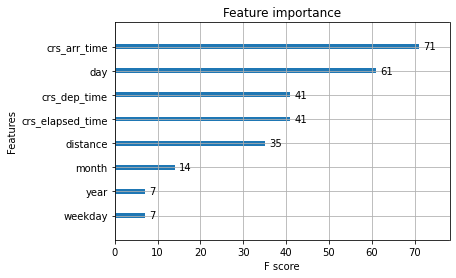

In [46]:
#Examine the importance of each feature column in the original data set with the model
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

##### Linear Regression

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X=scaler.fit_transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# creating linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_lr = lr.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_lr)))
print('Model R2 Score is: ',r2_score(y_test,y_lr))

Model RMSE is:  42.95885333539575
Model R2 Score is:  0.012317816661276626


##### Ridge/Lasso Regression

In [16]:
ridgereg = Ridge(alpha=0.001,normalize=True)
ridge = ridgereg.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_ridge))

lassoreg = Lasso(alpha=0.001,normalize=True)
lasso = lassoreg.fit(X_train,y_train)
y_pred_lasso = lasso.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_lasso))

Model RMSE is:  42.95886730894122
Model R2 Score is:  0.012317174119724439
Model RMSE is:  42.97763976657027
Model R2 Score is:  0.011453776814409844


##### Random Forest

In [19]:
#Create a Gaussian Regressor
clf=RandomForestRegressor(n_estimators=100)

In [20]:
#Train the model using the training sets 
clf.fit(X_train,y_train)

RandomForestRegressor()

In [21]:
y_pred=clf.predict(X_test)

In [22]:
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print('Model R2 Score is: ',r2_score(y_test,y_pred))

Model RMSE is:  44.296988970266796
Model R2 Score is:  -0.020367116177496092
